In [1]:
#imports for user defined functions
import acquire as aq
import prepare as prep
import explore as ex

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Planning #

**Business Goals Goals**

- The goal of this project is to find drivers of churn at Telco and answer the question: "Why are customers churning? 
- Construct a Machine Learning classification model that can accurately predict customer churn.
- Deliver a report that a layman can read through and understand the process and steps taken to reach insights.
- Finally, make a recommendation to stakeholders.


**Initial Questions to Answer**

- Is there a service type more associated with churn than expected?
- Is a certain payment or contract type associated with higher churn?
- Do customers who churn have higher average monthly charges?
- Do monthly charges increase with tenure? How does this affect churn?


**Minimum Viable Product**
- Using exploratory analysis, find drivers of churn that can be used as features in a classification model that will predict churn at a rate greater than the baseline.

In [2]:
#Acquire data using user defined function 
telco = aq.get_telco_data()
telco.head()

Using cached csv...


,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [3]:
#Initial sanity check -- internet_service_type_id, payment_type_id, contract_type_id are all duplicated
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
telco.isnull().sum() # No nulls detected

internet_service_type_id    0
payment_type_id             0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
payment_type                0
internet_service_type       0
dtype: int64

# Data Cleaning/Prep

array([[<AxesSubplot:title={'center':'internet_service_type_id'}>,
        <AxesSubplot:title={'center':'payment_type_id'}>],
       [<AxesSubplot:title={'center':'contract_type_id'}>,
        <AxesSubplot:title={'center':'senior_citizen'}>],
       [<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'monthly_charges'}>]], dtype=object)

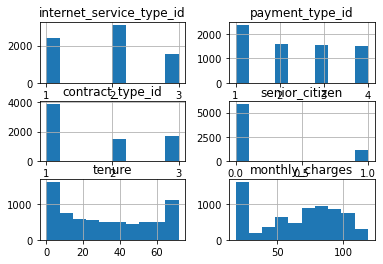

In [5]:
telco.hist()

In [6]:
#No phone service value is duplicated in phone service column
telco.multiple_lines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64

In [7]:
#No internet service value will be duplicated with internet_service_type column
telco.online_security.value_counts() 

# The same will go for online_backup, device_protection, tech_support, steaming_tv, and streaming_movies
# Will need to encode these to avoid the duplication

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64

In [8]:
# Creating function for initial data cleaning and prep

def prep_telco(telco):
    #Dropping potential duplicates
    telco.drop_duplicates(inplace = True)
    
    #Removing leading and trailing spaces
    telco['total_charges'] = telco['total_charges'].str.strip()
    #Removing rows where tenure and total_charges = 0
    telco = telco[telco.total_charges != '']
    #Changing total_charges to appropriate data type
    telco['total_charges'] = telco.total_charges.astype(float)
   
    #Dropping duplicate columns
    columns_to_drop = ['contract_type_id', 'payment_type_id', 'internet_service_type_id']
    telco = telco.drop(columns = columns_to_drop)

    #Encoding binary categorical variables
    telco['partner'] = telco.partner.map({'Yes': 1, 'No': 0})
    telco['dependents'] = telco.dependents.map({'Yes': 1, 'No': 0})
    telco['phone_service'] = telco.phone_service.map({'Yes': 1, 'No': 0})
    telco['paperless_billing'] = telco.paperless_billing.map({'Yes': 1, 'No': 0})
    telco['churn'] = telco.churn.map({'Yes': 1, 'No': 0})
    
    #Encoding other columns to remove duplicates between phone service and internet service type
    to_replace ={'Yes': 1, 'No': 0, 'No phone service':0, 'No internet service': 0}
    telco = telco.replace(to_replace)
    
    
    #Creating dummy variables for necessary columns and concatenating to data frame, then dropping the extra columns
    #Leaving drop_first as False for initial clarity
    dummy_telco = pd.get_dummies(telco[['gender','contract_type', 'payment_type', 'internet_service_type']], 
                         dummy_na = False, 
                         drop_first = False)
    telco = pd.concat([telco, dummy_telco], axis = 1)
    telco = telco.drop(columns= ['gender', 'contract_type', 'payment_type', 'internet_service_type'])
    
    return telco

In [9]:
# Use function to clean data 
## Sanity check

clean_telco = prep_telco(telco)
clean_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             7032 non-null   object 
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   int64  
 3   dependents                              7032 non-null   int64  
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   int64  
 6   multiple_lines                          7032 non-null   int64  
 7   online_security                         7032 non-null   int64  
 8   online_backup                           7032 non-null   int64  
 9   device_protection                       7032 non-null   int64  
 10  tech_support                            7032 non-null   int6

In [10]:
clean_telco.isnull().sum()

customer_id                               0
senior_citizen                            0
partner                                   0
dependents                                0
tenure                                    0
phone_service                             0
multiple_lines                            0
online_security                           0
online_backup                             0
device_protection                         0
tech_support                              0
streaming_tv                              0
streaming_movies                          0
paperless_billing                         0
monthly_charges                           0
total_charges                             0
churn                                     0
gender_Female                             0
gender_Male                               0
contract_type_Month-to-month              0
contract_type_One year                    0
contract_type_Two year                    0
payment_type_Bank transfer (auto

In [11]:
# Renaming columns 

to_rename = {'gender_Female': 'female', 'gender_Male': 'male', 
             'contract_type_Month-to-month': 'monthly_contract',
             'contract_type_One year': 'one_yr_contract', 
             'contract_type_Two year': 'two_yr_contract', 
             'payment_type_Bank transfer (automatic)': 'auto_bank_transfer', 
             'payment_type_Credit card (automatic)': 'auto_credit_card',
             'payment_type_Electronic check': 'electronic_check',
             'payment_type_Mailed check': 'mailed_check',
             'internet_service_type_DSL': 'dsl',
             'internet_service_type_Fiber optic': 'fiber_optic',
             'internet_service_type_None': 'no_internet'}

clean_telco = clean_telco.rename(columns=to_rename)
clean_telco[(clean_telco.no_internet) == 1]

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,monthly_contract,one_yr_contract,two_yr_contract,auto_bank_transfer,auto_credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet
20,0023-UYUPN,1,1,0,50,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
23,0030-FNXPP,0,0,0,3,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
24,0031-PVLZI,0,1,1,4,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
27,0040-HALCW,0,1,1,54,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
28,0042-JVWOJ,0,0,0,26,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,9970-QBCDA,0,0,0,6,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
7028,9972-EWRJS,0,1,1,67,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
7032,9975-GPKZU,0,1,1,46,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
7033,9975-SKRNR,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1


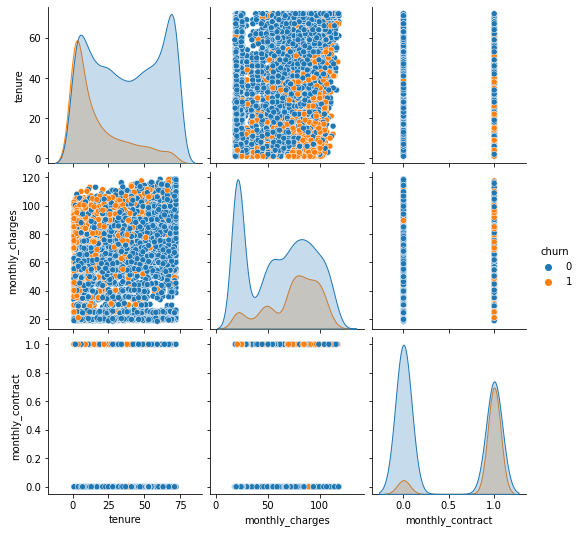

In [12]:
#Visualize relationship of churn with some variables
sns.pairplot(clean_telco[['tenure', 'monthly_charges', 'monthly_contract', 'churn']], hue='churn')

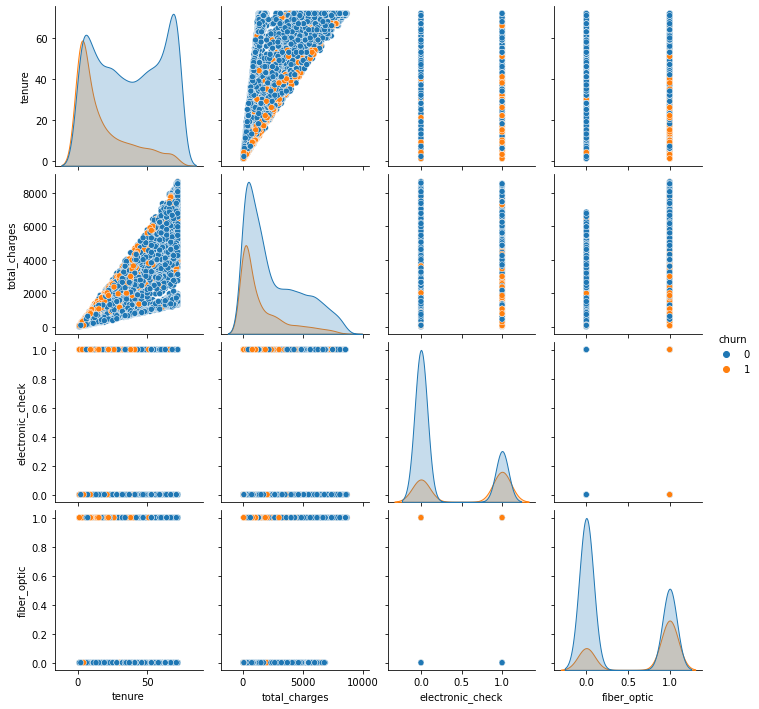

In [13]:
sns.pairplot(clean_telco[['tenure', 'total_charges', 'electronic_check', 'fiber_optic', 'churn']], hue='churn')

In [14]:
#Test my prepare.py file
df = prep.prep_telco(telco)
df.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,monthly_contract,one_yr_contract,two_yr_contract,auto_bank_transfer,auto_credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet
0,0002-ORFBO,0,1,1,9,1,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
1,0003-MKNFE,0,0,0,9,1,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
2,0004-TLHLJ,0,0,0,4,1,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
3,0011-IGKFF,1,1,0,13,1,0,0,1,1,...,1,0,0,0,0,1,0,0,1,0
4,0013-EXCHZ,1,1,0,3,1,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0


# Data splitting

In [16]:
train_validate, test = train_test_split(df, test_size=.2,
                                       random_state=123,
                                       stratify=df.churn)
    
train, validate = train_test_split(train_validate, test_size=.3,
                                  random_state=123,
                                  stratify=train_validate.churn)

print(train.shape)
print(validate.shape)
print(test.shape)

(3937, 29)
(1688, 29)
(1407, 29)


In [17]:
# Creating x & y version of train, validate, test
X_train = train.drop(columns=['churn', 'customer_id'])
y_train = train.churn

X_validate = validate.drop(columns=['churn', 'customer_id'])
y_validate = validate.churn

X_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

In [18]:
#Sanity check
X_train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,monthly_contract,one_yr_contract,two_yr_contract,auto_bank_transfer,auto_credit_card,electronic_check,mailed_check,dsl,fiber_optic,no_internet
5919,0,0,0,58,1,1,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
1915,0,0,1,71,1,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
5054,0,1,1,35,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2355,0,1,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
6279,1,0,0,20,1,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
